In [1]:
IMG_SIZE = 28
DATADIR = "dataset"

In [2]:
import os
CATEGORIES = [ f.path for f in os.scandir(DATADIR) if f.is_dir() ]
for i in range(len(CATEGORIES)):
    CATEGORIES[i] = CATEGORIES[i].replace(DATADIR+'\\', '')
    
print(CATEGORIES)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


In [4]:
# import the necessary packages
from keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras import backend as K

In [5]:
class SmallVGGNet:
	@staticmethod
	def build(width, height, depth, classes):
		# initialize the model along with the input shape to be
		# "channels last" and the channels dimension itself
		model = Sequential()
		inputShape = (height, width, depth)
		chanDim = -1

		# if we are using "channels first", update the input shape
		# and channels dimension
		if K.image_data_format() == "channels_first":
			inputShape = (depth, height, width)
			chanDim = 1

		# CONV => RELU => POOL layer set
		model.add(Conv2D(32, (3, 3), padding="same", input_shape=inputShape))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(MaxPooling2D(pool_size=(2, 2)))
		model.add(Dropout(0.25))

		# (CONV => RELU) * 2 => POOL layer set
		model.add(Conv2D(64, (3, 3), padding="same"))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(Conv2D(64, (3, 3), padding="same"))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(MaxPooling2D(pool_size=(2, 2)))
		model.add(Dropout(0.25))

		# (CONV => RELU) * 3 => POOL layer set
		model.add(Conv2D(128, (3, 3), padding="same"))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(Conv2D(128, (3, 3), padding="same"))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(Conv2D(128, (3, 3), padding="same"))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(MaxPooling2D(pool_size=(2, 2)))
		model.add(Dropout(0.25))

		# first (and only) set of FC => RELU layers
		model.add(Flatten())
		model.add(Dense(512))
		model.add(Activation("relu"))
		model.add(BatchNormalization())
		model.add(Dropout(0.5))

		# softmax classifier
		model.add(Dense(classes))
		model.add(Activation("softmax"))

		# return the constructed network architecture
		return model

In [7]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import random
import pickle
import cv2
import os

In [8]:
# initialize the data and labels
print("[INFO] loading images...")
data = []
labels = []

[INFO] loading images...


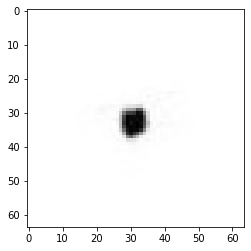

In [9]:
for category in CATEGORIES:  # do dogs and cats
    path = os.path.join(DATADIR, category)
    for img in os.listdir(path):  # iterate over each image per dogs and cats
        img_array = cv2.imread(os.path.join(path, img))  # convert to array
        plt.imshow(img_array, cmap='gray')  # graph it
        plt.show()  # display!
        break  # we just want one for now so break
    break  #...and one more!

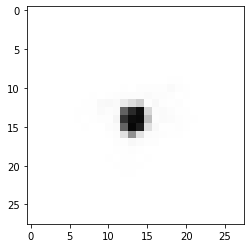

In [10]:
new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
plt.imshow(new_array, cmap='gray')
plt.show()

In [11]:
from tqdm import tqdm
training_data = []
def create_training_data():
    for category in CATEGORIES:  # do dogs and cats
        path = os.path.join(DATADIR, category)  # create path to dogs and cats
        class_num = CATEGORIES.index(category)  # get the classification  (0 or a 1). 0=dog 1=cat

        for img in tqdm(os.listdir(path)):  # iterate over each image per dogs and cats
            try:
                img_array = cv2.imread(os.path.join(path, img))  # convert to array
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  # resize to normalize data size
                training_data.append([new_array, class_num])  # add this to our training_data
            except Exception as e:  # in the interest in keeping the output clean...
                pass
            #except OSError as e:
            #    print("OSErrroBad img most likely", e, os.path.join(path,img))
            #except Exception as e:
            #    print("general exception", e, os.path.join(path,img))

In [12]:
create_training_data()

100%|█████████████████████████████████████████| 21/21 [00:00<00:00, 247.04it/s]


In [13]:
import random
random.shuffle(training_data)

data = []
labels = []

for features, label in training_data:
    data.append(features)
    labels.append(label)

data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)

print(data.shape)
print(labels.shape)

(211, 28, 28, 3)
(211,)


In [14]:
(trainX, testX, trainY, testY) = train_test_split(data,
	labels, test_size=0.25, random_state=42)

In [15]:
lb = LabelBinarizer()
trainY = lb.fit_transform(trainY)
testY = lb.transform(testY)

In [16]:
aug = ImageDataGenerator(rotation_range=30, width_shift_range=0.1,
	height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
	horizontal_flip=True, fill_mode="nearest")

In [17]:
model = SmallVGGNet.build(width=IMG_SIZE, height=IMG_SIZE, depth=3,
	classes=len(lb.classes_))

In [18]:
print(trainX.shape)
print(testX.shape)

(158, 28, 28, 3)
(53, 28, 28, 3)


In [19]:
INIT_LR = 0.01
EPOCHS = 70
BS = 32
# initialize the model and optimizer (you'll want to use
# binary_crossentropy for 2-class classification)
print("[INFO] training network...")
opt = SGD(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
# train the network
H = model.fit(x=aug.flow(trainX, trainY, batch_size=BS), validation_data=(testX, testY), steps_per_epoch=len(trainX) // BS, epochs=EPOCHS)

[INFO] training network...


c:\python37\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/70
4/4 [==============================] - 3s 404ms/step - loss: 3.2662 - accuracy: 0.1429 - val_loss: 2.3160 - val_accuracy: 0.0755
Epoch 2/70
4/4 [==============================] - 1s 261ms/step - loss: 3.1942 - accuracy: 0.1984 - val_loss: 2.3137 - val_accuracy: 0.0755
Epoch 3/70
4/4 [==============================] - 1s 263ms/step - loss: 2.9257 - accuracy: 0.1746 - val_loss: 2.3268 - val_accuracy: 0.1132
Epoch 4/70
4/4 [==============================] - 1s 262ms/step - loss: 2.6285 - accuracy: 0.2222 - val_loss: 2.3550 - val_accuracy: 0.1132
Epoch 5/70
4/4 [==============================] - 1s 324ms/step - loss: 2.3247 - accuracy: 0.2500 - val_loss: 2.3787 - val_accuracy: 0.1132
Epoch 6/70
4/4 [==============================] - 1s 302ms/step - loss: 2.4515 - accuracy: 0.3016 - val_loss: 2.4109 - val_accuracy: 0.1132
Epoch 7/70
4/4 [==============================] - 1s 274ms/step - loss: 2.5045 - accuracy: 0.3016 - val_loss: 2.4556 - val_accuracy: 0.1132
Epoch 8/70
4/4 [====

4/4 [==============================] - 1s 270ms/step - loss: 0.6937 - accuracy: 0.7500 - val_loss: 5.9117 - val_accuracy: 0.0755
Epoch 60/70
4/4 [==============================] - 1s 264ms/step - loss: 0.8511 - accuracy: 0.7344 - val_loss: 6.4476 - val_accuracy: 0.0755
Epoch 61/70
4/4 [==============================] - 1s 259ms/step - loss: 0.7486 - accuracy: 0.7698 - val_loss: 6.2530 - val_accuracy: 0.0755
Epoch 62/70
4/4 [==============================] - 1s 262ms/step - loss: 0.5524 - accuracy: 0.8047 - val_loss: 6.3684 - val_accuracy: 0.0755
Epoch 63/70
4/4 [==============================] - 1s 255ms/step - loss: 0.5426 - accuracy: 0.7857 - val_loss: 5.2771 - val_accuracy: 0.1698
Epoch 64/70
4/4 [==============================] - 1s 262ms/step - loss: 0.3743 - accuracy: 0.8810 - val_loss: 4.7086 - val_accuracy: 0.1887
Epoch 65/70
4/4 [==============================] - 1s 267ms/step - loss: 0.6247 - accuracy: 0.7812 - val_loss: 4.9967 - val_accuracy: 0.1698
Epoch 66/70
4/4 [========

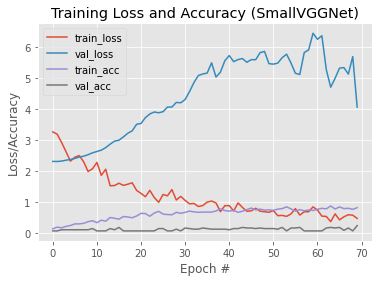

In [20]:
N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.plot(N, H.history["accuracy"], label="train_acc")
plt.plot(N, H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy (SmallVGGNet)")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

In [22]:
import cv2
import numpy as np
import tensorflow as tf

def prepare(filepath):
    img_array = cv2.imread(filepath)
    img_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
    img_array = np.array(img_array, dtype="float") / 255.0
    img_array = img_array.reshape(-1, IMG_SIZE, IMG_SIZE, 3)
    return img_array

path=r'dataset\4\img.1.jpg'
prediction = model.predict(prepare(path))

maximum = 0
index = 0
for i in range(len(CATEGORIES)):
    if (prediction[0][i]) > maximum:
        index = i
        maximum = prediction[0][i]
print(CATEGORIES[index])

print(prediction)

1
[[1.8231988e-04 9.9537778e-01 3.3199529e-03 2.2926338e-06 2.6857864e-05
  2.5653517e-06 7.7727447e-05 8.8733752e-05 9.1777579e-04 3.9840020e-06]]


In [24]:
model.save("p-mnist.model")

INFO:tensorflow:Assets written to: p-mnist.model\assets
